<a target="_blank" href="https://colab.research.google.com/github/rcabanasdepaz/ME-BigData/blob/main/JAGS/MixGaussians2_.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Mixtura multivariante de gausianas con modelos jerárquicos (JAGS)

A continuación se muestra cómo ajustar una mixtura de gausianas mediante un modelo probabilístico jerárquico.


In [ ]:
install.packages("R2OpenBUGS")
library(R2OpenBUGS)


system("sudo apt-get install -y jags") # Sólo para colab o sistemas Linux
install.packages("rjags")
library(rjags)


install.packages("coda")
library(coda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




## Conjunto de datos


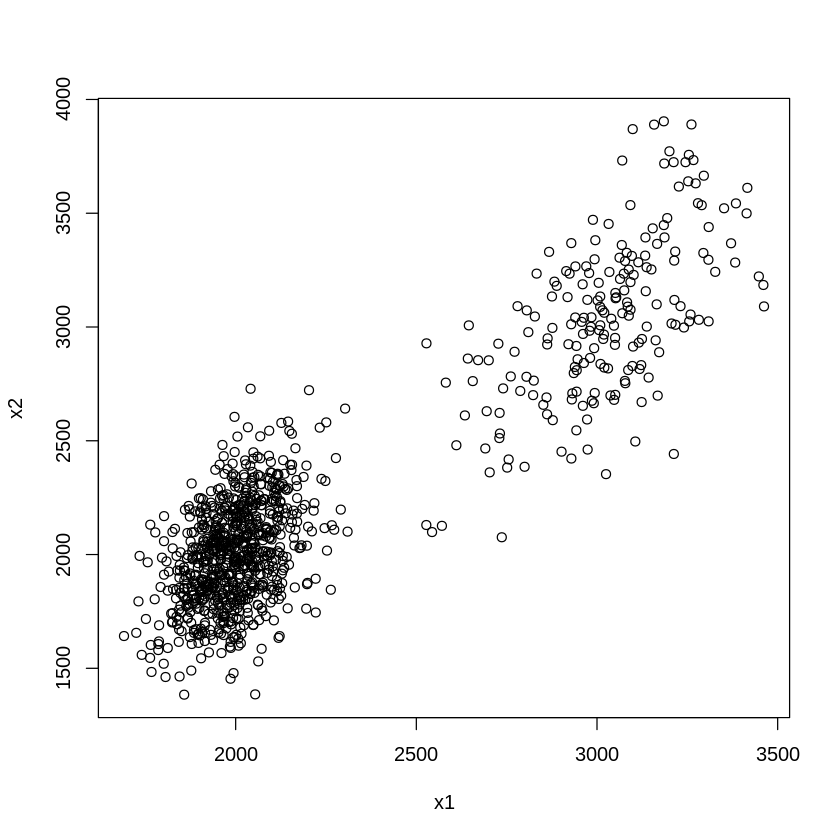

In [ ]:
# Generamos un conjunto de datos
set.seed(47405)

ingresos1 <-rnorm(800,2000,100)
ingresos2 <-rnorm(200,3000,200)

x1 = c(ingresos1,ingresos2)
x2 = x1 * rnorm(length(x1), 1,0.1)
plot(x1,x2)

In [ ]:

n = length(x1)

# Necesitamos asignar como minimo 2 clusters
Ngrupos = 2
grupo = rep(NA,n)
grupo[which.min(x)]=1
grupo[which.max(x)]=2
X = cbind(x1,x2)
dataList = list(
  X = X,
  n = n ,
  Ngrupos = Ngrupos ,
  grupo = grupo ,
  paramGrupos = rep(1,Ngrupos)
)



## Modelo 1
### Definición
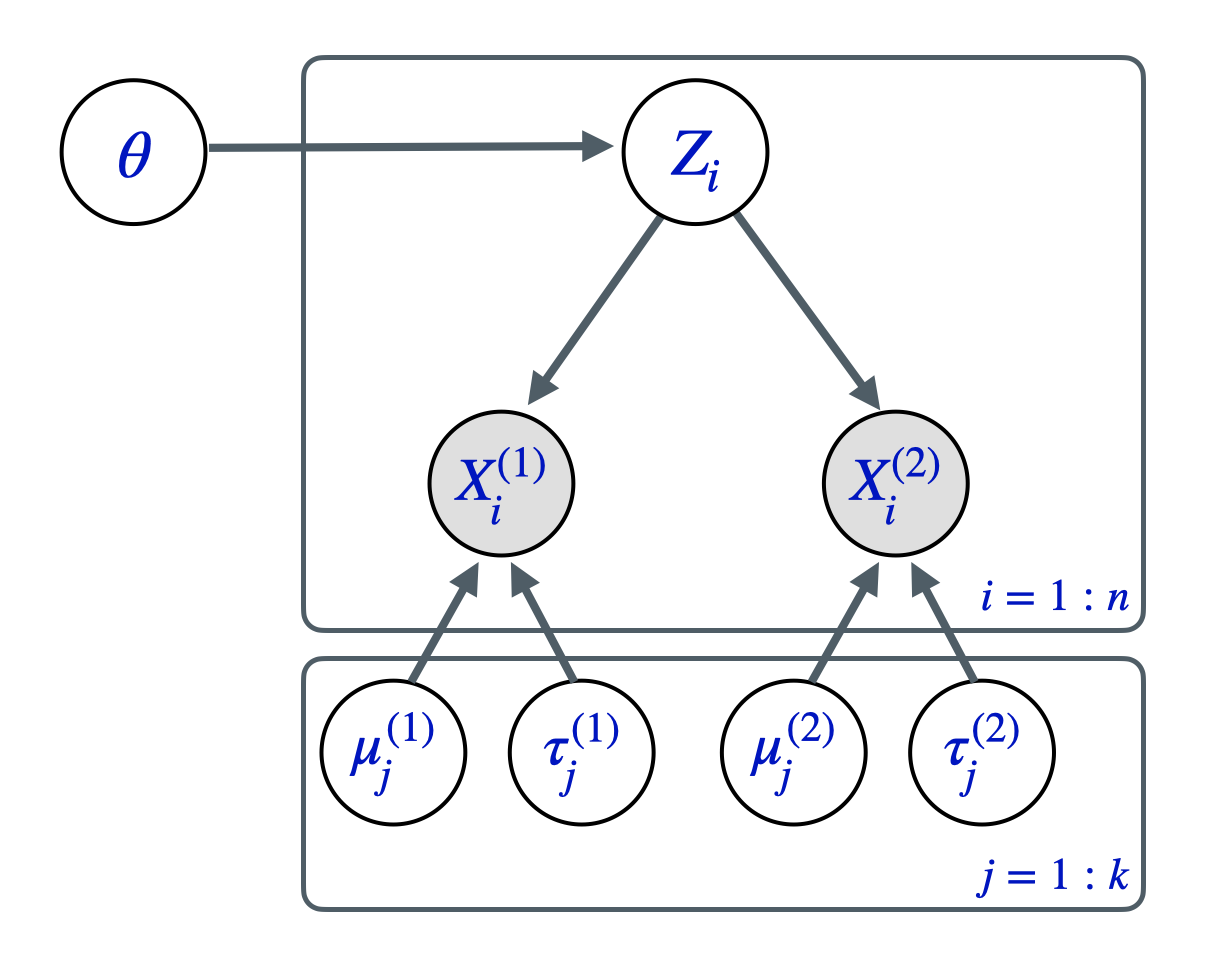

Podemos definir el modelo como una función:

In [ ]:
# Un modelo en rjags es una función
mod = function(){
  # Dist. a priori:
  for ( grupoId in 1: Ngrupos ) {
    for(d in 1:2) {
      muGrupo[grupoId,d] ~ dnorm( 0 , 1.0E-10 )
      tauGrupo[grupoId,d] ~ dgamma( 0.01 , 0.01 )
    }
  }
  pGrupo[1:Ngrupos] ~ ddirch( paramGrupos )


  # verosimilitud
  for( i in 1 : n ) {
        for(d in 1:2) {
          X[i,d] ~ dnorm( mu[i,d] , tau[i,d] )
          mu[i,d] <- muGrupo[grupo[i],d]
          tau[i,d] <- tauGrupo[grupo[i],d]
        }
        grupo[i] ~ dcat( pGrupo[1:Ngrupos] )

    }
}

### Inferencia

Puesto que JAGS es un software externo a R, para poder hacer inferencia hacer inferenc

In [ ]:

# hay que guardar el modelo en un archivo
model.file="model.txt"
write.model(mod,model.file)

# compilamos el modelo
jmod = jags.model(file = model.file, data=dataList, inits = NULL, n.adapt = 1000)


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2002
   Unobserved stochastic nodes: 1007
   Total graph size: 7009

Initializing model



In [ ]:
update(jmod, n.iter=1000, by=1)

In [ ]:
# Muestreamos la secuencia completa
samples = jags.samples(jmod,c('grupo', 'X', 'mu','tau', 'grupo', 'tauGrupo', 'muGrupo'), 100)
theta = prop.table(table(samples$grupo))

Warning message in FUN(X[[i]], ...):
“Failed to set trace monitor for grupo
Monitor already exists and cannot be duplicated
”


In [ ]:
samples$muGrupo

mcarray:
         [,1]     [,2]
[1,] 1995.964 2003.539
[2,] 3017.718 3034.790

Marginalizing over: iteration(100),chain(1) 

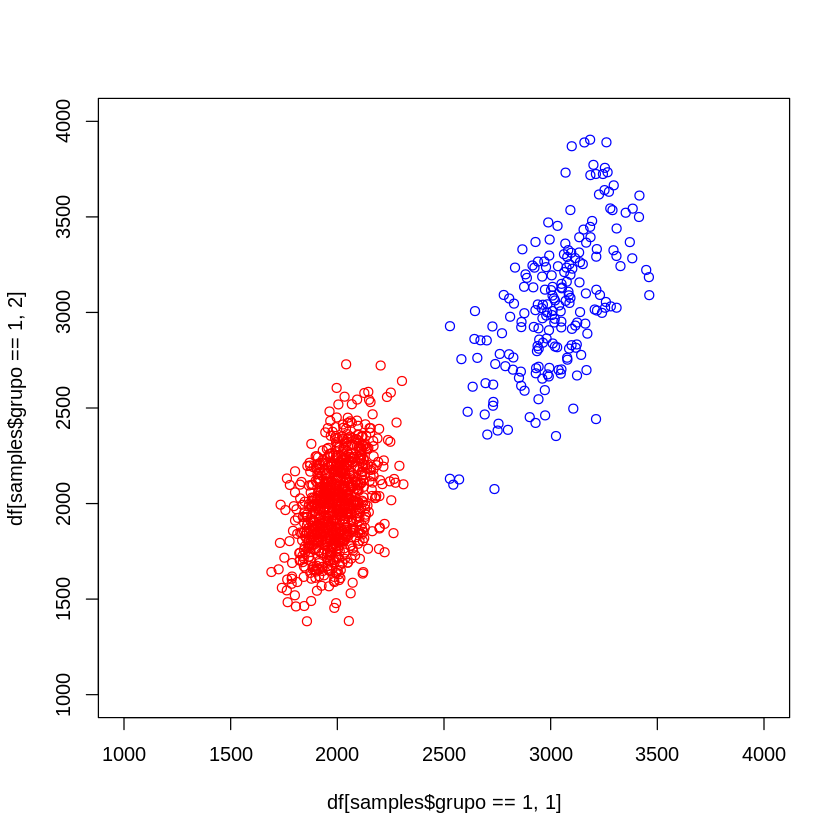

In [ ]:
df = data.frame(x1=x1,x2=x2)
plot(df[samples$grupo==1,1], df[samples$grupo==1,2], col="red", xlim=c(1000,4000), ylim=c(1000,4000))
points(df[samples$grupo!=1,1], df[samples$grupo!=1,2], col="blue")

## Ejercicios

- Indica cómo sería la versión extendida del modelo jerárquico.
- ¿Cómo sería una red Bayesiana híbrida equivalente?


## Enlaces
- Para crear notebooks con código en R: https://colab.research.google.com/#create=true&language=r